In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pygeos
import geopandas as gpd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import interpolate
import seaborn as sns
import pyproj
import pygeos
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from rasterstats import zonal_stats

# path to python scripts
sys.path.append(os.path.join('..','src','trails'))

from population_OD import *

from network import *

In [2]:
def get_area_km2(geometries):
    """This method adds a distance column using pygeos (converted from shapely) 
    assuming the new crs from the latitude and longitude of the first node
    distance is in metres

    Args:
        network (class): A network composed of nodes (points in space) and edges (lines)

    Returns:
        network (class): A network composed of nodes (points in space) and edges (lines)
    """    

    #Find crs of current df and arbitrary point(lat,lon) for new crs
    current_crs="epsg:4326"
    #The commented out crs does not work in all cases
    #current_crs = [*network.edges.crs.values()]
    #current_crs = str(current_crs[0])
    lat = pygeos.get_y(pygeos.centroid(geometry))
    lon = pygeos.get_x(pygeos.centroid(geometry))
    # formula below based on :https://gis.stackexchange.com/a/190209/80697 
    approximate_crs = "epsg:" + str(int(32700-np.round((45+lat)/90,0)*100+np.round((183+lon)/6,0)))
    #from pygeos/issues/95
    coords = pygeos.get_coordinates(geometry)
    transformer=pyproj.Transformer.from_crs(current_crs, approximate_crs,always_xy=True)
    new_coords = transformer.transform(coords[:, 0], coords[:, 1])
    result = pygeos.set_coordinates(geometry, np.array(new_coords).T)
    return pygeos.area(result)

def get_average_slope(geometry):
    slope_path = 'C:\Data\Global_Geospatial\geo\dtm_slope_merit.dem_m_1km_s0..0cm_2017_v1.0.tif'
    out = zonal_stats(geometry,slope_path)[0]
    return out['mean'],out['max']

def get_total_population(geometry):
    geo_path = 'C:\Data\Global_Geospatial\worldpop\ppp_2018_1km_Aggregated.tif'
    out = zonal_stats(geometry,geo_path,stats='sum')[0]
    return out['sum']

def get_builtup_area(geometry):
    geo_path = 'C:\Data\Global_Geospatial//builtuparea\GHS_builtup_wgs84.tif'
    out = zonal_stats(geometry,geo_path)[0]
    return out['mean']

def add_landlocked(country_code):
    
    landlocked = ['AFG','AND','ARM','AUT','AZE','BLR','BTN','BOL','BFA','BDI','CAF','TCD','CZE',
    'SWZ','ETH','HUN','KAZ','KGZ','LAO','LSO','LTE','LUX','MWI','MLI','MDA','MNG',
    'NPL','NER','MKD','PRY','RWA','SRB','SVK','SSD','CHE','TJK','TKM','UGA','UZB','ZMB','ZWE']

    if country_code in landlocked:
        return 1
    else:
        return 0
    
def connect_area(area_dict,x):
    try:
        return area_dict[x]
    except:
        return 0    

In [3]:
# set data paths to results
data_random_attack = r'C:\Data\Global_Percolation\percolation_results_random_attack_regular'
data_targeted_attack = r'C:\Data\Global_Percolation\percolation_results_targeted_attack'
data_local_attack_05 = r'C:\Data\Global_Percolation\percolation_results_local_attack_05'
data_local_attack_01 = r'C:\Data\Global_Percolation\percolation_results_local_attack_01'
data_local_attack_005 = r'C:\Data\Global_Percolation\percolation_results_local_attack_005'

data_path_met= r'C:\Data\Global_Percolation\percolation_metrics'
data_path_net = r'C:\Data\Global_Percolation\percolation_networks'
data_path_grids = r'C:\Data\Global_Percolation\percolation_grids'

# file to get full country names
glob_info = pd.read_excel(r'C:\Projects\trails\data\global_information.xlsx')
gdp_cap_country = pd.read_csv(r'C:\trails\data\percolation\worldbank_gdp_2019.csv',sep=';')
income_groups = pd.read_excel(r'C:\trails\data\percolation\CLASS.xls',sheet_name='Groups')

# get all files from data paths
perc_files_random_attack = os.listdir(data_random_attack)
perc_files_targeted_attack = os.listdir(data_targeted_attack)
perc_files_local_attack_05 = os.listdir(data_local_attack_05)
perc_files_local_attack_01 = os.listdir(data_local_attack_01)
perc_files_local_attack_005 = os.listdir(data_local_attack_005)

grid_files = os.listdir(data_path_grids)

met_files = os.listdir(data_path_met)
net_files = os.listdir(data_path_net)

In [4]:
income_groups = income_groups.loc[(income_groups.GroupName.str.contains('High income')) | (
     income_groups.GroupName.str.contains('Upper middle income')) | (
     income_groups.GroupName.str.contains('Lower middle income')) | (
     income_groups.GroupName.str.contains('Low income'))].reset_index(drop=True)

In [5]:
gadm36 = gpd.read_file(r'C:/Data/Global_Geospatial/GADM/gadm36_levels.gpkg',layer=0)
py_geoms = pygeos.from_shapely(gadm36.geometry.values)
gadm36.geometry = py_geoms

In [6]:
tqdm.pandas()
slopes = gadm36.geometry.progress_apply(lambda x: get_average_slope(x))
gadm36[['mean_slope', 'max_slope']] = pd.DataFrame(slopes.tolist(), index=slopes.index)

gadm36['builtarea'] = gadm36.geometry.progress_apply(lambda x: get_builtup_area(x))

population = gadm36.geometry.progress_apply(lambda x: get_total_population(x))
gadm36[['tot_pop']] = pd.DataFrame(population.tolist(), index=population.index)

gadm36['landlocked'] = gadm36.GID_0.progress_apply(lambda x: add_landlocked(x))

collect_area = []
for geometry in tqdm(py_geoms,total=len(py_geoms)):
    collect_area.append(get_area_km2(geometry)/1e6) 
gadm36['area'] = collect_area

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:16<00:00, 15.96it/s]


In [7]:
area_dict = dict(zip(gadm36['GID_0'],gadm36['area']))
continent_dict = dict(zip(glob_info['ISO_3digit'],glob_info['continent']))
sids_dict = dict(zip(glob_info['ISO_3digit'],glob_info['SIDS']))
gdp_cap_dict = dict(zip(gdp_cap_country['iso'],gdp_cap_country['gdp']))
income_dict = dict(zip(income_groups['CountryCode'],income_groups['GroupName']))
mean_slope_dict = dict(zip(gadm36['GID_0'],gadm36['mean_slope']))
max_slope_dict = dict(zip(gadm36['GID_0'],gadm36['max_slope']))
landlocked_dict = dict(zip(gadm36['GID_0'],gadm36['landlocked']))
population_dict = dict(zip(gadm36['GID_0'],gadm36['tot_pop']))
builtup_dict = dict(zip(gadm36['GID_0'],gadm36['builtarea']))

In [8]:
glob_info['area'] = glob_info.ISO_3digit.apply(lambda x: connect_area(area_dict,x)) 

In [9]:
%%time
urban_areas = gpd.read_file(r'C:\Data\Global_Geospatial\GHS_STAT_UCDB2015MT_GLOBE_R2019A\GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
urban_areas = pd.DataFrame(urban_areas.copy())
urban_areas.geometry = pygeos.make_valid(pygeos.from_shapely(urban_areas.geometry))
tree = pygeos.STRtree(urban_areas.geometry.values)

Wall time: 3.99 s


In [10]:
# connect facts to grids
for country in (glob_info.ISO_3digit.values):
    network = 0
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
     
    except:
         print('{} has no 05 grid!'.format(country))
            
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
     
    except:
         print('{} has no 01 grid!'.format(country))
            
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
     
    except:
         print('{} has no 005 grid!'.format(country))            

CCK has no 05 grid!
CCK has no 01 grid!
CCK has no 005 grid!
SJM has no 05 grid!
SJM has no 01 grid!
SJM has no 005 grid!
SPM has no 05 grid!
SPM has no 01 grid!
SPM has no 005 grid!
UMI has no 05 grid!
UMI has no 01 grid!
UMI has no 005 grid!
PCN has no 05 grid!
PCN has no 01 grid!
PCN has no 005 grid!
SGS has no 05 grid!
SGS has no 01 grid!
SGS has no 005 grid!
ANT has no 05 grid!
ANT has no 01 grid!
ANT has no 005 grid!
TKL has no 05 grid!
TKL has no 01 grid!
TKL has no 005 grid!
TUV has no 05 grid!
TUV has no 01 grid!
TUV has no 005 grid!


In [11]:
country_metrics = {}

for country in tqdm(glob_info.ISO_3digit.values,total=len(glob_info.ISO_3digit.values)):
    network = 0
    #specify file
    
    collect_metrics = {}

    file = '{}_{}_results.csv'.format(country,network)
    
    try:
        # load metrics
        df_metrics = pd.read_csv(os.path.join(data_path_met,[x for x in met_files if file[:5] in x][0]))

        collect_metrics['general'] = (df_metrics.Density.values[0],df_metrics.Clique_No.values[0],df_metrics.Edge_Connectivity.values[0],
                                     df_metrics.Ave_Path_Length.values[0],df_metrics.Assortativity.values[0],
                                     df_metrics.Diameter.values[0],df_metrics.Max_Degree.values[0],df_metrics.Transivitity.values[0],
                                     df_metrics.Articulation_Points.values[0],df_metrics.Total_Edge_Length.values[0])
        
        
    except:
        continue
        
    # 0.5 degree
    try:
        df_local_05 = pd.read_csv(os.path.join(data_local_attack_05,file),index_col=[0])
        grid_05 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
        grid_05 = grid_05.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_05.grid_no.loc[grid_05.urban == True].values
        
        df_local_05_urban = df_local_05.loc[df_local_05.grid_no.isin(urban_grids)]
        df_local_05_rural = df_local_05.loc[~df_local_05.grid_no.isin(urban_grids)]

        isolated_05 = df_local_05.loc[df_local_05.pct_isolated != 0].reset_index(drop=True)           
        delayed_05 = df_local_05.loc[df_local_05.pct_delayed != 0].reset_index(drop=True)

        isolated_05_urban = df_local_05_urban.loc[df_local_05_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_05_urban = df_local_05_urban.loc[df_local_05_urban.pct_delayed != 0].reset_index(drop=True)
        
        isolated_05_rural = df_local_05_rural.loc[df_local_05_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_05_rural = df_local_05_rural.loc[df_local_05_rural.pct_delayed != 0].reset_index(drop=True)
        
        if len(df_local_05) > 0:
            perc_isolated_trips = round(len(isolated_05)/len(df_local_05)*100,2)
            perc_delayed_trips = round(len(delayed_05)/len(df_local_05)*100,2)

            if len(isolated_05) > 0:
                avg_isolated = round(isolated_05.pct_isolated.mean(),2)   
                max_isolated = round(isolated_05.pct_isolated.max(),2)   
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_05) > 0:
                avg_delayed = round(delayed_05.pct_delayed.mean(),2)
                max_delayed = round(delayed_05.pct_delayed.mean(),2)   
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0

        if len(df_local_05_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_05_urban)/len(df_local_05_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_05_urban)/len(df_local_05_urban)*100,2)

            if len(isolated_05_urban) > 0:
                avg_isolated_urban = round(isolated_05_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_05_urban.pct_isolated.max(),2)   
                
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_05_urban) > 0:
                avg_delayed_urban = round(delayed_05_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_05_urban.pct_delayed.max(),2)
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0
            max_delayed_urban = 0
            
        if len(df_local_05_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_05_rural)/len(df_local_05_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_05_rural)/len(df_local_05_rural)*100,2)

            if len(isolated_05_rural) > 0:
                avg_isolated_rural = round(isolated_05_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_05_rural.pct_isolated.max(),2)   
                
            else:
                avg_isolated_rural = 0
                max_isolated_rural = 0

            if len(delayed_05_rural) > 0:
                avg_delayed_rural = round(delayed_05_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_05_rural.pct_delayed.max(),2)   
                
            else:
                avg_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_05'] = (len(grid_05),len(df_local_05),len(df_local_05_urban),len(df_local_05_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
                                         
    except:
        None
    
    # 0.1 degree
    try:
        df_local_01 = pd.read_csv(os.path.join(data_local_attack_01,file),index_col=[0])
        grid_01 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
        grid_01 = grid_01.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_01.grid_no.loc[grid_01.urban == True].values

        df_local_01_urban = df_local_01.loc[df_local_01.grid_no.isin(urban_grids)]
        df_local_01_rural = df_local_01.loc[~df_local_01.grid_no.isin(urban_grids)]

        isolated_01 = df_local_01.loc[df_local_01.pct_isolated != 0].reset_index(drop=True)           
        delayed_01 = df_local_01.loc[df_local_01.pct_delayed != 0].reset_index(drop=True)

        isolated_01_urban = df_local_01_urban.loc[df_local_01_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_01_urban = df_local_01_urban.loc[df_local_01_urban.pct_delayed != 0].reset_index(drop=True)

        isolated_01_rural = df_local_01_rural.loc[df_local_01_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_01_rural = df_local_01_rural.loc[df_local_01_rural.pct_delayed != 0].reset_index(drop=True)

        if len(df_local_01) > 0:
            perc_isolated_trips = round(len(isolated_01)/len(df_local_01)*100,2)
            perc_delayed_trips = round(len(delayed_01)/len(df_local_01)*100,2)

            if len(isolated_01) > 0:
                avg_isolated = round(isolated_01.pct_isolated.mean(),2) 
                max_isolated = round(isolated_01.pct_isolated.max(),2) 
            else:
                avg_isolated = 0
                max_isolated = 0


            if len(delayed_01) > 0:
                avg_delayed = round(delayed_01.pct_delayed.mean(),2)
                max_delayed = round(delayed_01.pct_delayed.max(),2) 
                
            else:
                avg_delayed = 0
                max_delayed = 0
                
        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0
            
        if len(df_local_01_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_01_urban)/len(df_local_01_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_01_urban)/len(df_local_01_urban)*100,2)

            if len(isolated_01_urban) > 0:
                avg_isolated_urban = round(isolated_01_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_01_urban.pct_isolated.max(),2)   
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_01_urban) > 0:
                avg_delayed_urban = round(delayed_01_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_01_urban.pct_delayed.max(),2)   
                
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0            
            max_delayed_urban = 0

        if len(df_local_01_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_01_rural)/len(df_local_01_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_01_rural)/len(df_local_01_rural)*100,2)

            if len(isolated_01_rural) > 0:
                avg_isolated_rural = round(isolated_01_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_01_rural.pct_isolated.max(),2)   
            else:
                avg_isolated_rural = 0

            if len(delayed_01_rural) > 0:
                avg_delayed_rural = round(delayed_01_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_01_rural.pct_delayed.max(),2)   
                
            else:
                avg_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_01'] = (len(grid_01),len(df_local_01),len(df_local_01_urban),len(df_local_01_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
    except:
        None        
        
    # 0.05 degree
    try:
        df_local_005 = pd.read_csv(os.path.join(data_local_attack_005,file),index_col=[0])
        grid_005 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
        grid_005 = grid_005.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_005.grid_no.loc[grid_005.urban == True].values
        
        df_local_005_urban = df_local_005.loc[df_local_005.grid_no.isin(urban_grids)]
        df_local_005_rural = df_local_005.loc[~df_local_005.grid_no.isin(urban_grids)]

        isolated_005 = df_local_005.loc[df_local_005.pct_isolated != 0].reset_index(drop=True)           
        delayed_005 = df_local_005.loc[df_local_005.pct_delayed != 0].reset_index(drop=True)

        isolated_005_urban = df_local_005_urban.loc[df_local_005_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_005_urban = df_local_005_urban.loc[df_local_005_urban.pct_delayed != 0].reset_index(drop=True)
        
        isolated_005_rural = df_local_005_rural.loc[df_local_005_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_005_rural = df_local_005_rural.loc[df_local_005_rural.pct_delayed != 0].reset_index(drop=True)
        
        if len(df_local_005) > 0:
            perc_isolated_trips = round(len(isolated_005)/len(df_local_005)*100,2)
            perc_delayed_trips = round(len(delayed_005)/len(df_local_005)*100,2)

            if len(isolated_005) > 0:
                avg_isolated = round(isolated_005.pct_isolated.mean(),2)  
                max_isolated = round(isolated_005.pct_isolated.max(),2)   
                
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_005) > 0:
                avg_delayed = round(delayed_005.pct_delayed.mean(),2)
                max_delayed = round(delayed_005.pct_delayed.max(),2)   
                
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0
            
        if len(df_local_005_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_005_urban)/len(df_local_005_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_005_urban)/len(df_local_005_urban)*100,2)

            if len(isolated_005_urban) > 0:
                avg_isolated_urban = round(isolated_005_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_005_urban.pct_isolated.max(),2)   
                
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_005_urban) > 0:
                avg_delayed_urban = round(delayed_005_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_005_urban.pct_delayed.max(),2)
                
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0
            max_delayed_urban = 0 
             
            
        if len(df_local_005_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_005_rural)/len(df_local_005_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_005_rural)/len(df_local_005_rural)*100,2)

            if len(isolated_005_rural) > 0:
                avg_isolated_rural = round(isolated_005_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_005_rural.pct_isolated.max(),2)   
                
            else:
                avg_isolated_rural = 0
                max_isolated_rural = 0

            if len(delayed_005_rural) > 0:
                avg_delayed_rural = round(delayed_005_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_005_rural.pct_delayed.max(),2)
                
            else:
                avg_delayed_rural = 0
                max_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_005'] = (len(grid_005),len(df_local_005),len(df_local_005_urban),len(df_local_005_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
    except:
        None
        
    # target attack
    try:
        df_target = pd.read_csv(os.path.join(data_targeted_attack,file),index_col=[0])
        isolated_target = df_target.loc[df_target.pct_isolated != 0].reset_index(drop=True)
        delayed_target = df_target.loc[df_target.pct_delayed != 0].reset_index(drop=True)
        if len(df_target) > 0:
            
            if country == 'USA':
                perc_isolated_trips = round(len(isolated_target)/(2047684)*100,2)
                perc_delayed_trips = round(len(delayed_target)/(2047684)*100,2)
            elif country == 'CHN':
                perc_isolated_trips = round(len(isolated_target)/(1721065)*100,2)
                perc_delayed_trips = round(len(delayed_target)/(1721065)*100,2)
            else:
                perc_isolated_trips = round(len(isolated_target)/len(df_target)*100,2)
                perc_delayed_trips = round(len(delayed_target)/len(df_target)*100,2)

            if len(isolated_target) > 0:
                avg_isolated = round(isolated_target.pct_isolated.mean(),2)   
                max_isolated = round(isolated_target.pct_isolated.max(),2)   
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_target) > 0:
                avg_delayed = round(delayed_target.pct_delayed.mean(),2)
                max_delayed = round(delayed_target.pct_delayed.max(),2)   
                
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0
            max_delayed = 0
            
        collect_metrics['target'] = len(df_target),perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed
    except:
        None
        
        # random attack
    try:
        df_random = pd.read_csv(os.path.join(data_random_attack,file),index_col=[0])
        df_random.frac_counter = df_random.frac_counter*100

        df_mean_random = df_random.groupby('frac_counter').mean()
        df_max_random = df_random.groupby('frac_counter').quantile(q=0.95)#.max()
        df_min_random = df_random.groupby('frac_counter').quantile(q=0.05)#.min()

        max_isolated = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_isolated = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_isolated = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_delayed = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_delayed = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_delayed = [round(interpolate.interp1d(df_max_random.index.values,df_min_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_unaffected = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_unaffected = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_unaffected = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_sloss_e1 = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_sloss_e1 = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_sloss_e1 = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_sloss_e2 = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_sloss_e2 = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_sloss_e2 = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
     
        collect_metrics['random'] = max_isolated,mean_isolated,min_isolated,max_delayed,mean_delayed,min_delayed,max_unaffected,mean_unaffected,min_unaffected,max_sloss_e1,mean_sloss_e1,min_sloss_e1,max_sloss_e2,mean_sloss_e2,min_sloss_e2,

    except:
        None
    
    country_metrics[country] = collect_metrics 
    

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [04:16<00:00,  1.08s/it]


In [12]:
def add_country_data(country):
    try:
        return country,income_dict[country],gdp_cap_dict[country],area_dict[country],continent_dict[country],sids_dict[country],mean_slope_dict[country],max_slope_dict[country],landlocked_dict[country],population_dict[country],builtup_dict[country]
    except:
        return country,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

collect_random = {}
collect_target = {}
collect_local05 = {}
collect_local01 = {}
collect_local005 = {}
collect_random_od_buffer = {}
collect_general = {}

for country in tqdm(glob_info.ISO_3digit.values,total=len(glob_info.ISO_3digit.values)):
    try:
        collect_general[country] = country_metrics[country]['general']
    except:
        None
    try:
        collect_random[country] = country_metrics[country]['random']
        collect_random_od_buffer[country] = country_metrics[country]['random_od_buffer']      
    except:
        None
    try:
        collect_target[country] = country_metrics[country]['target']   
    except:
        None
        
    try:
        collect_local05[country] = country_metrics[country]['local_05']        
    except:
        None
        
    try:
        collect_local01[country] = country_metrics[country]['local_01']        
    except:
        None
        
    try:
        collect_local005[country] = country_metrics[country]['local_005']        
    except:
        None        

100%|████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 237754.14it/s]


In [13]:
df_general = pd.DataFrame(collect_general).T
df_general.columns = ['Density', 'Clique_No','Edge_Connectivity','Ave_Path_Length', 'Assortativity', 'Diameter','Max_Degree',"Transivitity","Articulation_Points",'Total_Edge_Length']

In [14]:
random_results = pd.DataFrame(collect_random).T
random_results.columns = ['max_isolated','mean_isolated','min_isolated','max_delayed','mean_delayed','min_delayed',
                          'max_unaffected','mean_unaffected','min_unaffected','max_sloss_e1','mean_sloss_e1','min_sloss_e1','max_sloss_e2','mean_sloss_e2','min_sloss_e2',]

country_info = pd.DataFrame(random_results.reset_index()['index'].apply(lambda x : add_country_data(x)).tolist())
country_info.dropna(axis=0)
country_info.columns = ['ISO3','IncomeLevel','GDP_CAP','AreaKM','Continent','SIDS','mean_slope','max_slope','landlocked','population','builtarea']

random_min_isolated = pd.DataFrame(random_results.min_isolated.tolist(), index= random_results.index)
random_min_isolated = random_min_isolated.fillna(100)
random_min_isolated = random_min_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_isolated = pd.DataFrame(random_results.mean_isolated.tolist(), index= random_results.index)
random_mean_isolated = random_mean_isolated.fillna(100)
random_mean_isolated = random_mean_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_isolated = pd.DataFrame(random_results.max_isolated.tolist(), index= random_results.index)
random_max_isolated = random_max_isolated.fillna(100)
random_max_isolated = random_max_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

In [15]:
random_min_delayed = pd.DataFrame(random_results.min_delayed.tolist(), index= random_results.index)
random_min_delayed = random_min_delayed.fillna(100)
random_min_delayed = random_min_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_delayed = pd.DataFrame(random_results.mean_delayed.tolist(), index= random_results.index)
random_mean_delayed = random_mean_delayed.fillna(100)
random_mean_delayed = random_mean_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_delayed = pd.DataFrame(random_results.max_delayed.tolist(), index= random_results.index)
random_max_delayed = random_max_delayed.fillna(100)
random_max_delayed = random_max_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

In [16]:
random_min_sloss_e1 = pd.DataFrame(random_results.min_sloss_e1.tolist(), index= random_results.index)
random_min_sloss_e1 = random_min_sloss_e1.fillna(100)
random_min_sloss_e1 = random_min_sloss_e1.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_sloss_e1 = pd.DataFrame(random_results.mean_sloss_e1.tolist(), index= random_results.index)
random_mean_sloss_e1 = random_mean_sloss_e1.fillna(100)
random_mean_sloss_e1 = random_mean_sloss_e1.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_sloss_e1 = pd.DataFrame(random_results.max_sloss_e1.tolist(), index= random_results.index)
random_max_sloss_e1 = random_max_sloss_e1.fillna(100)
random_max_sloss_e1 = random_max_sloss_e1.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_min_sloss_e2 = pd.DataFrame(random_results.min_sloss_e2.tolist(), index= random_results.index)
random_min_sloss_e2 = random_min_sloss_e2.fillna(100)
random_min_sloss_e2 = random_min_sloss_e2.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_sloss_e2 = pd.DataFrame(random_results.mean_sloss_e2.tolist(), index= random_results.index)
random_mean_sloss_e2 = random_mean_sloss_e2.fillna(100)
random_mean_sloss_e2 = random_mean_sloss_e2.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_sloss_e2 = pd.DataFrame(random_results.max_sloss_e2.tolist(), index= random_results.index)
random_max_sloss_e2 = random_max_sloss_e2.fillna(100)
random_max_sloss_e2 = random_max_sloss_e2.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

In [17]:
random_mean_isolated['Edge_Area'] = random_mean_isolated.Total_Edge_Length/random_mean_isolated.AreaKM
random_min_isolated['Edge_Area'] = random_min_isolated.Total_Edge_Length/random_min_isolated.AreaKM
random_max_isolated['Edge_Area'] = random_max_isolated.Total_Edge_Length/random_max_isolated.AreaKM

In [18]:
random_mean_delayed['Edge_Area'] = random_mean_delayed.Total_Edge_Length/random_mean_delayed.AreaKM
random_min_delayed['Edge_Area'] = random_min_delayed.Total_Edge_Length/random_min_delayed.AreaKM
random_max_delayed['Edge_Area'] = random_max_delayed.Total_Edge_Length/random_max_delayed.AreaKM
random_mean_sloss_e1['Edge_Area'] = random_mean_sloss_e1.Total_Edge_Length/random_mean_sloss_e1.AreaKM
random_min_sloss_e1['Edge_Area'] = random_min_sloss_e1.Total_Edge_Length/random_min_sloss_e1.AreaKM
random_max_sloss_e1['Edge_Area'] = random_max_sloss_e1.Total_Edge_Length/random_max_sloss_e1.AreaKM

In [19]:
random_mean_affected = random_mean_isolated.copy()
random_max_affected = random_max_isolated.copy()
random_min_affected = random_min_isolated.copy()

random_mean_affected.iloc[:,:100] = random_mean_delayed.iloc[:,:100] + random_mean_isolated.iloc[:,:100]
random_max_affected.iloc[:,:100] = random_max_delayed.iloc[:,:100] + random_max_isolated.iloc[:,:100]
random_min_affected.iloc[:,:100] = random_min_delayed.iloc[:,:100] + random_min_isolated.iloc[:,:100]

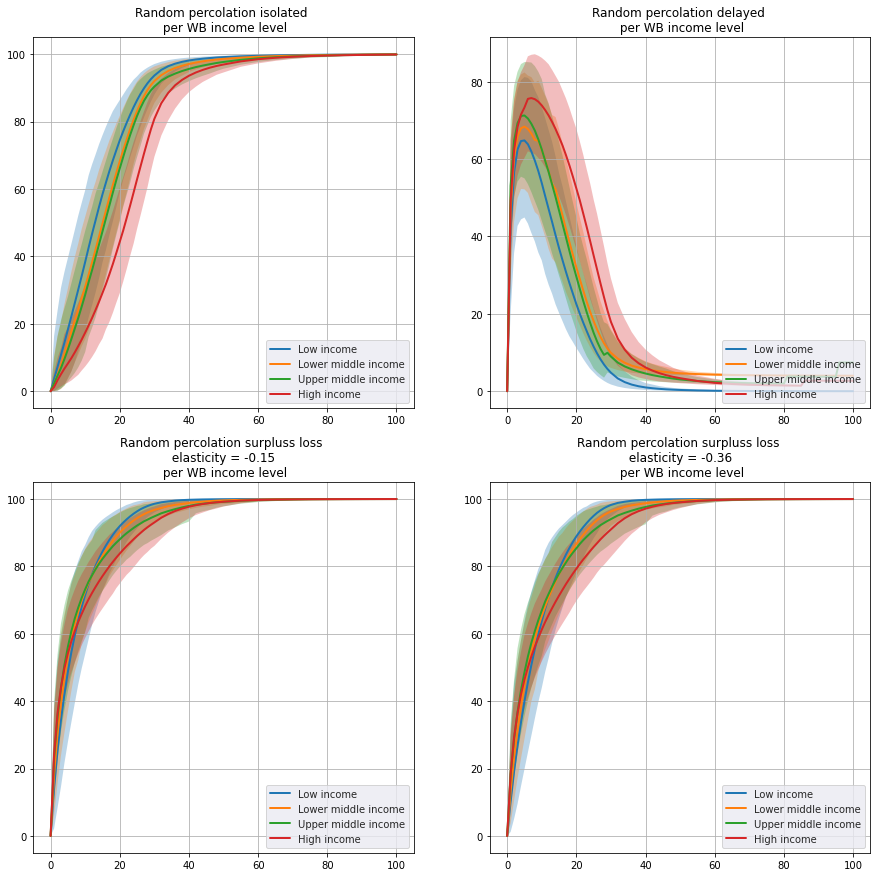

In [20]:
fig, axes = plt.subplots(2,2,figsize=(15,15))

clrs = sns.color_palette("tab10")

income_groups = ['Low income','Lower middle income','Upper middle income','High income']
for iter_,ax in enumerate(axes.flatten()):
    
    if iter_ == 0:
        with sns.axes_style("darkgrid"):
            epochs = list(range(101))
            for i in range(4):
                if i == 0:
                    meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
                    min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
                    max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
                elif i == 1:
                    meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
                elif i == 2:
                    meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                elif i == 3:
                    meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['High income']
                    min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['High income']
                    max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['High income']           

                ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
                ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
            ax.legend(loc=4)   
            ax.grid()
            ax.set_title('Random percolation isolated \n per WB income level')
            
            
    elif iter_ == 1:
        with sns.axes_style("darkgrid"):
            epochs = list(range(101))
            for i in range(4):
                if i == 0:
                    meanst = random_mean_delayed.groupby('IncomeLevel').mean().T[:101]['Low income']
                    min_plot = random_min_delayed.groupby('IncomeLevel').mean().T[:101]['Low income']
                    max_plot = random_max_delayed.groupby('IncomeLevel').mean().T[:101]['Low income']
                elif i == 1:
                    meanst = random_mean_delayed.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    min_plot = random_min_delayed.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    max_plot = random_max_delayed.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
                elif i == 2:
                    meanst = random_mean_delayed.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    min_plot = random_min_delayed.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    max_plot = random_max_delayed.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                elif i == 3:
                    meanst = random_mean_delayed.groupby('IncomeLevel').mean().T[:101]['High income']
                    min_plot = random_min_delayed.groupby('IncomeLevel').mean().T[:101]['High income']
                    max_plot = random_max_delayed.groupby('IncomeLevel').mean().T[:101]['High income']           

                ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
                ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
            ax.legend(loc=4)
    
            ax.grid()
            ax.set_title('Random percolation delayed \n per WB income level')      
            
            
    elif iter_ == 2:
        with sns.axes_style("darkgrid"):
            epochs = list(range(101))
            for i in range(4):
                if i == 0:
                    meanst = random_mean_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Low income']
                    min_plot = random_min_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Low income']
                    max_plot = random_max_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Low income']
                elif i == 1:
                    meanst = random_mean_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    min_plot = random_min_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    max_plot = random_max_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
                elif i == 2:
                    meanst = random_mean_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    min_plot = random_min_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    max_plot = random_max_sloss_e1.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                elif i == 3:
                    meanst = random_mean_sloss_e1.groupby('IncomeLevel').mean().T[:101]['High income']
                    min_plot = random_min_sloss_e1.groupby('IncomeLevel').mean().T[:101]['High income']
                    max_plot = random_max_sloss_e1.groupby('IncomeLevel').mean().T[:101]['High income']           

                ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
                ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
            ax.legend(loc=4)
    
            ax.grid()
            ax.set_title('Random percolation surpluss loss \n elasticity = -0.15 \n per WB income level')          
            
    elif iter_ == 3:
        with sns.axes_style("darkgrid"):
            epochs = list(range(101))
            for i in range(4):
                if i == 0:
                    meanst = random_mean_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Low income']
                    min_plot = random_min_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Low income']
                    max_plot = random_max_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Low income']
                elif i == 1:
                    meanst = random_mean_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    min_plot = random_min_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
                    max_plot = random_max_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
                elif i == 2:
                    meanst = random_mean_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    min_plot = random_min_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                    max_plot = random_max_sloss_e2.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
                elif i == 3:
                    meanst = random_mean_sloss_e2.groupby('IncomeLevel').mean().T[:101]['High income']
                    min_plot = random_min_sloss_e2.groupby('IncomeLevel').mean().T[:101]['High income']
                    max_plot = random_max_sloss_e2.groupby('IncomeLevel').mean().T[:101]['High income']           

                ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
                ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
            ax.legend(loc=4)
    
            ax.grid()
            ax.set_title('Random percolation surpluss loss \n elasticity = -0.36 \n per WB income level')          

In [21]:
def get_gradients(random_df): 
    collect_mean_gradient = {}
    collect_100_point = {}
    for column in random_df.T[:101].columns:
        points = random_df.T[:101][column].values
        collect_mean_gradient[column] = np.argmax(np.abs(np.gradient(points))),np.max(np.abs(np.gradient(points)))
        collect_100_point[column] = np.argmax(np.abs((points)))
        
    return collect_mean_gradient,collect_100_point

collect_mean_gradient,collect_100_point = get_gradients(random_mean_isolated)
random_mean_isolated = random_mean_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_mean_isolated = random_mean_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_mean_isolated['logGDP'] = np.log(random_mean_isolated.GDP_CAP)
random_mean_isolated['logPOP'] = np.log(random_mean_isolated.population)
random_mean_delayed['logGDP'] = np.log(random_mean_isolated.GDP_CAP)
random_mean_delayed['logPOP'] = np.log(random_mean_isolated.population)
random_mean_sloss_e1['logGDP'] = np.log(random_mean_isolated.GDP_CAP)
random_mean_sloss_e1['logPOP'] = np.log(random_mean_isolated.population)


collect_mean_gradient,collect_100_point = get_gradients(random_min_isolated)
random_min_isolated = random_min_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_min_isolated = random_min_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_min_isolated['logGDP'] = np.log(random_min_isolated.GDP_CAP)
random_min_isolated['logPOP'] = np.log(random_min_isolated.population)
random_min_delayed['logGDP'] = np.log(random_min_isolated.GDP_CAP)
random_min_delayed['logPOP'] = np.log(random_min_isolated.population)
random_min_sloss_e1['logGDP'] = np.log(random_min_isolated.GDP_CAP)
random_min_sloss_e1['logPOP'] = np.log(random_min_isolated.population)


collect_mean_gradient,collect_100_point = get_gradients(random_max_isolated)
random_max_isolated = random_max_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_max_isolated = random_max_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_max_isolated['logGDP'] = np.log(random_max_isolated.GDP_CAP)
random_max_isolated['logPOP'] = np.log(random_max_isolated.population)
random_max_delayed['logGDP'] = np.log(random_max_isolated.GDP_CAP)
random_max_delayed['logPOP'] = np.log(random_max_isolated.population)
random_max_sloss_e1['logGDP'] = np.log(random_max_isolated.GDP_CAP)
random_max_sloss_e1['logPOP'] = np.log(random_max_isolated.population)


In [22]:
#05
local_results_05 = pd.DataFrame(collect_local05).T
local_results_05.columns = ['no_grids_05','no_grids_wroads_05','urban_grids_wroads_05','rural_grids_wroads_05',
                           'pct_grids_cause_isolation_05','avg_pct_trips_isolated_05','max_pct_trips_isolated_05',
                            'pct_grids_cause_delay_05','avg_pct_trips_delayed_05','max_pct_trips_delayed_05',
                           'pct_urban_grids_cause_isolation_05','avg_pct_trips_isolated_urban_05','max_pct_trips_isolated_urban_05',
                            'pct_urban_grids_cause_delay_05','avg_pct_trips_delayed_urban_05','max_pct_trips_delayed_urban_05',
                           'pct_rural_grids_cause_isolation_05','avg_pct_trips_isolated_rural_05','max_pct_trips_isolated_rural_05',
                            'pct_rural_grids_cause_delay_05','avg_pct_trips_delayed_rural_05','max_pct_trips_delayed_rural_05']

local_results_05 = local_results_05.astype(float)
local_results_05 = local_results_05.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

#01
local_results_01 = pd.DataFrame(collect_local01).T
local_results_01.columns = ['no_grids_01','no_grids_wroads_01','urban_grids_wroads_01','rural_grids_wroads_01',
                           'pct_grids_cause_isolation_01','avg_pct_trips_isolated_01','max_pct_trips_isolated_01',
                            'pct_grids_cause_delay_01','avg_pct_trips_delayed_01','max_pct_trips_delayed_01',
                           'pct_urban_grids_cause_isolation_01','avg_pct_trips_isolated_urban_01','max_pct_trips_isolated_urban_01',
                            'pct_urban_grids_cause_delay_01','avg_pct_trips_delayed_urban_01','max_pct_trips_delayed_urban_01',
                           'pct_rural_grids_cause_isolation_01','avg_pct_trips_isolated_rural_01','max_pct_trips_isolated_rural_01',
                            'pct_rural_grids_cause_delay_01','avg_pct_trips_delayed_rural_01','max_pct_trips_delayed_rural_01']
local_results_01 = local_results_01.astype(float)
local_results_01 = local_results_01.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

#005
local_results_005 = pd.DataFrame(collect_local005).T
local_results_005.columns = ['no_grids_005_005','no_grids_wroads_005','urban_grids_wroads_005','rural_grids_wroads_005',
                           'pct_grids_cause_isolation_005','avg_pct_trips_isolated_005','max_pct_trips_isolated_005',
                            'pct_grids_cause_delay_005','avg_pct_trips_delayed_005','max_pct_trips_delayed_005',
                           'pct_urban_grids_cause_isolation_005','avg_pct_trips_isolated_urban_005','max_pct_trips_isolated_urban_005',
                            'pct_urban_grids_cause_delay_005','avg_pct_trips_delayed_urban_005','max_pct_trips_delayed_urban_005',
                           'pct_rural_grids_cause_isolation_005','avg_pct_trips_isolated_rural_005','max_pct_trips_isolated_rural_005',
                            'pct_rural_grids_cause_delay_005','avg_pct_trips_delayed_rural_005','max_pct_trips_delayed_rural']
local_results_005 = local_results_005.astype(float)
local_results_005 = local_results_005.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)


local_results_05['logGDP_CAP'] = np.log(local_results_05.GDP_CAP)
local_results_01['logGDP_CAP'] = np.log(local_results_01.GDP_CAP)
local_results_005['logGDP_CAP'] = np.log(local_results_005.GDP_CAP)

local_results_05['logAREA'] = np.log(local_results_05.AreaKM)
local_results_01['logAREA'] = np.log(local_results_01.AreaKM)
local_results_005['logAREA'] = np.log(local_results_005.AreaKM)

local_results_05['logPOP'] = np.log(local_results_05.population)
local_results_01['logPOP'] = np.log(local_results_01.population)
local_results_005['logPOP'] = np.log(local_results_005.population)

local_results_05['POP_AREA'] = local_results_05.population/local_results_05.AreaKM
local_results_01['POP_AREA'] = local_results_01.population/local_results_01.AreaKM
local_results_005['POP_AREA'] = local_results_005.population/local_results_005.AreaKM

#target
target_results = pd.DataFrame(collect_target).T
target_results.columns = ['no_edges','pct_edges_cause_isolation','avg_pct_trips_isolated','max_pct_trips_isolated',
                          'pct_edges_cause_delay','avg_pct_trips_delayed','max_pct_trips_delayed']
target_results = target_results.astype(float)
target_results = target_results.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)
target_results['logGDP_CAP'] = np.log(target_results.GDP_CAP)
target_results['logAREA'] = np.log(target_results.AreaKM)
target_results['logPOP'] = np.log(target_results.population)
target_results['POP_AREA'] = target_results.population/target_results.AreaKM
target_results['logEdges'] = np.log(target_results.Total_Edge_Length)

In [23]:
local_results_05.to_csv('../results/local_attack_05degree.csv')
local_results_01.to_csv('../results/local_attack_01degree.csv')
local_results_005.to_csv('../results/local_attack_005degree.csv')
target_results.to_csv('../results/targeted_attack.csv')

<AxesSubplot:xlabel='Total_Edge_Length', ylabel='max_pct_trips_isolated_005'>

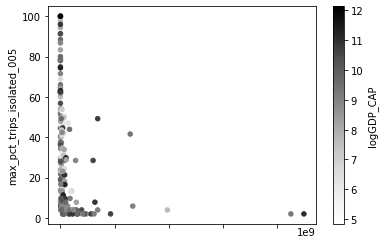

In [24]:
local_results_005.plot.scatter(x='Total_Edge_Length',y='max_pct_trips_isolated_005',c='logGDP_CAP')

In [25]:
all_columns_to_jenk = ['AreaKM','Total_Edge_Length','builtarea','Edge_Area','max_slope','mean_slope']

for column_to_jenk in all_columns_to_jenk:
    jenks = random_mean_isolated[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    random_mean_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_mean_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_min_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_min_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_max_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_max_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])
    
    random_mean_delayed['{}_binned'.format(column_to_jenk)] = pd.cut(random_mean_delayed[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_min_delayed['{}_binned'.format(column_to_jenk)] = pd.cut(random_min_delayed[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_max_delayed['{}_binned'.format(column_to_jenk)] = pd.cut(random_max_delayed[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])
    
    random_mean_sloss_e1['{}_binned'.format(column_to_jenk)] = pd.cut(random_mean_sloss_e1[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_min_sloss_e1['{}_binned'.format(column_to_jenk)] = pd.cut(random_min_sloss_e1[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_max_sloss_e1['{}_binned'.format(column_to_jenk)] = pd.cut(random_max_sloss_e1[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])    

In [26]:
from scipy.stats import pearsonr,spearmanr,kendalltau
import numpy as np
rho = target_results.corr()
pval = target_results.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
(rho.round(2).astype(str) + p)#.sort_values('pct_grids_cause_isolation_05',ascending=False).head(20)

,no_edges,pct_edges_cause_isolation,avg_pct_trips_isolated,max_pct_trips_isolated,pct_edges_cause_delay,avg_pct_trips_delayed,max_pct_trips_delayed,GDP_CAP,AreaKM,SIDS,...,Diameter,Max_Degree,Transivitity,Articulation_Points,Total_Edge_Length,logGDP_CAP,logAREA,logPOP,POP_AREA,logEdges
no_edges,1.0***,-0.26***,-0.15***,-0.22***,-0.54***,-0.22***,-0.26***,0.15***,0.34***,-0.24***,...,0.66***,0.52***,0.01,0.42***,0.31***,0.28***,0.36***,0.44***,-0.06,0.51***
pct_edges_cause_isolation,-0.26***,1.0***,0.42***,0.63***,0.4***,0.35***,0.45***,-0.08***,-0.12***,0.49***,...,-0.36***,-0.38***,0.01,-0.16***,-0.16***,-0.15***,-0.31***,-0.47***,-0.04***,-0.52***
avg_pct_trips_isolated,-0.15***,0.42***,1.0***,0.67***,0.18***,0.8***,0.59***,-0.0***,-0.07***,0.38***,...,-0.23***,-0.32***,-0.01,-0.1***,-0.1***,-0.04***,-0.34***,-0.43***,0.11***,-0.48***
max_pct_trips_isolated,-0.22***,0.63***,0.67***,1.0***,0.19***,0.5***,0.68***,-0.1***,0.05,0.29***,...,-0.2***,-0.34***,-0.02,-0.14***,-0.14***,-0.28***,-0.13,-0.31***,-0.02***,-0.37***
pct_edges_cause_delay,-0.54***,0.4***,0.18***,0.19***,1.0***,0.31***,0.29***,0.01*,-0.34***,0.57***,...,-0.66***,-0.64***,0.09,-0.37***,-0.36***,-0.03*,-0.75***,-0.8***,0.13***,-0.83***
avg_pct_trips_delayed,-0.22***,0.35***,0.8***,0.5***,0.31***,1.0***,0.7***,-0.07***,-0.11***,0.45***,...,-0.31***,-0.42***,-0.23**,-0.14***,-0.14***,-0.09***,-0.41***,-0.52***,0.02***,-0.59***
max_pct_trips_delayed,-0.26***,0.45***,0.59***,0.68***,0.29***,0.7***,1.0***,-0.1***,-0.07***,0.38***,...,-0.24***,-0.39***,-0.13,-0.23***,-0.26***,-0.19***,-0.3***,-0.45***,-0.06*,-0.51***
GDP_CAP,0.15***,-0.08***,-0.0***,-0.1***,0.01*,-0.07***,-0.1***,1.0***,0.03***,-0.06,...,0.07**,0.01*,0.33***,0.05,0.08,0.76***,-0.32***,-0.26***,0.49***,-0.13
AreaKM,0.34***,-0.12***,-0.07***,0.05,-0.34***,-0.11***,-0.07***,0.03***,1.0***,-0.17***,...,0.72***,0.35***,-0.1***,0.64***,0.69***,0.06***,0.45***,0.36***,-0.08***,0.41***
SIDS,-0.24***,0.49***,0.38***,0.29***,0.57***,0.45***,0.38***,-0.06,-0.17***,1.0***,...,-0.37***,-0.41***,-0.04,-0.16***,-0.16***,0.09,-0.6***,-0.63***,0.06***,-0.68***


In [27]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(target_results.pct_edges_cause_isolation, target_results.logEdges)

In [28]:
slope,intercept,r_value,p_value,std_err

(-0.34399118633344977,
 16.800468247136198,
 -0.5178491689765685,
 1.145883249403356e-15,
 0.03959279761021363)

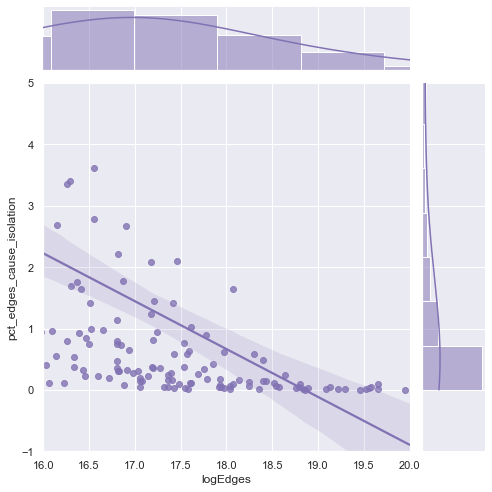

In [29]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="logEdges", y="pct_edges_cause_isolation", data=target_results,
                  kind="reg", truncate=False,
                  xlim=(16, 20), ylim=(-1, 5),
                  color="m", height=7)

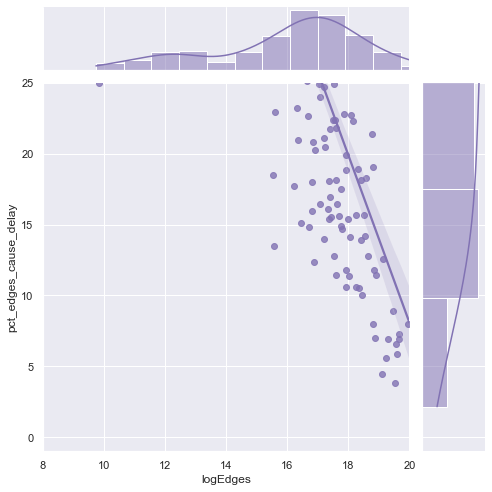

In [30]:
g = sns.jointplot(x="logEdges", y="pct_edges_cause_delay", data=target_results,
                  kind="reg", truncate=False,
                  xlim=(8, 20), ylim=(-1, 25),
                  color="m", height=7)

In [31]:
local_results_005.max_pct_trips_isolated_005.mean(),local_results_01.max_pct_trips_isolated_01.mean(),local_results_05.max_pct_trips_isolated_05.mean()

(27.216346153846153, 30.791249999999998, 43.78235576923077)

In [32]:
local_results_005.avg_pct_trips_isolated_005.mean(),local_results_01.avg_pct_trips_isolated_01.mean(),local_results_05.avg_pct_trips_isolated_05.mean()

(9.917548076923076, 13.486875000000001, 27.01899038461538)

In [33]:
local_results_05[local_results_05.max_pct_trips_isolated_05 >= 50].shape[0]/local_results_05.shape[0]

0.38461538461538464

In [34]:
all_columns_to_jenk = ['AreaKM','Total_Edge_Length','builtarea','max_slope','mean_slope']

for column_to_jenk in all_columns_to_jenk:
    jenks = target_results[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    target_results['{}_binned'.format(column_to_jenk)] = pd.cut(target_results[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])
    
    local_results_05['{}_binned'.format(column_to_jenk)] = pd.cut(local_results_05[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    local_results_01['{}_binned'.format(column_to_jenk)] = pd.cut(local_results_01[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])    
    
    local_results_005['{}_binned'.format(column_to_jenk)] = pd.cut(local_results_005[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])        

In [35]:
random_mean_isolated['mean_gradient_isolated_0_20'] = np.mean(np.gradient(random_mean_isolated.iloc[:,:20].values,axis=1),axis=1)
random_max_isolated['mean_gradient_isolated_0_20'] = np.mean(np.gradient(random_max_isolated.iloc[:,:20].values,axis=1),axis=1)
random_min_isolated['mean_gradient_isolated_0_20'] = np.mean(np.gradient(random_min_isolated.iloc[:,:20].values,axis=1),axis=1)

random_mean_isolated['mean_gradient_delayed_0_20'] = np.mean(np.gradient(random_mean_delayed.iloc[:,:20].values,axis=1),axis=1)
random_max_isolated['mean_gradient_delayed_0_20'] = np.mean(np.gradient(random_max_delayed.iloc[:,:20].values,axis=1),axis=1)
random_min_isolated['mean_gradient_delayed_0_20'] = np.mean(np.gradient(random_min_delayed.iloc[:,:20].values,axis=1),axis=1)

In [36]:
letters = ['A','B','C','D','E','F','G','H']

In [37]:
random_max_isolated.mean_gradient_delayed_0_20.mean()

4.385057692307693

In [38]:
random_mean_isolated.iloc[:,20].mean()

59.96937500000001

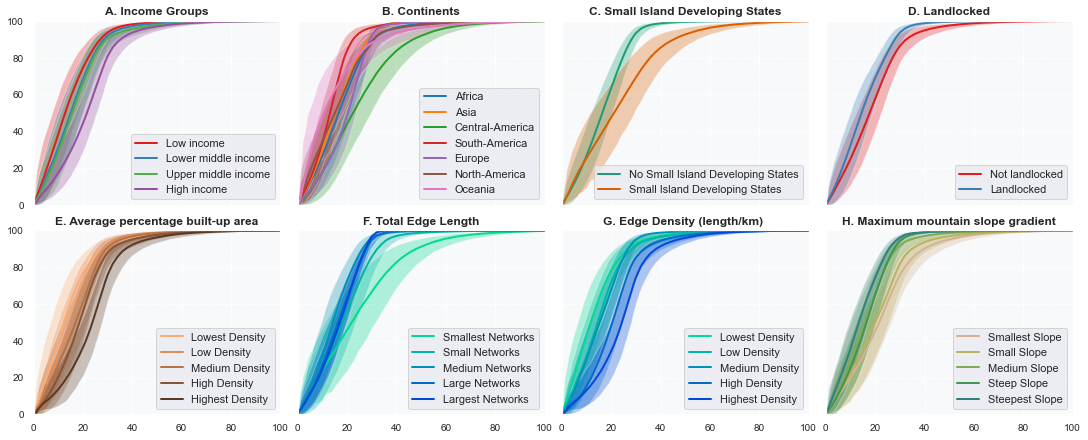

In [39]:
fig,axs = plt.subplots(2,4,figsize=(15,6),sharex=True,sharey=True,constrained_layout=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('{}. Income Groups'.format(letters[iter_]),fontweight='bold')
    elif iter_ == 1: #continents
        clrs = sns.color_palette("tab10")

        continents = ['Africa', 'Asia', 'Central-America', 'South-America', 'Europe', 'North-America',
               'Oceania']

        for i in range(len(continents)):
            meanst = random_mean_isolated.groupby('Continent').mean().T[:101][continents[i]]
            min_plot = random_min_isolated.groupby('Continent').mean().T[:101][continents[i]]
            max_plot = random_max_isolated.groupby('Continent').mean().T[:101][continents[i]]

            ax.plot(epochs, meanst, label=continents[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)

        ax.set_title('{}. Continents'.format(letters[iter_]),fontweight='bold')
           
    elif iter_ == 2: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Small Island Developing States'.format(letters[iter_]),fontweight='bold')
            
    elif iter_ == 3: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
        
    elif iter_ == 4: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Average percentage built-up area'.format(letters[iter_]),fontweight='bold')
            
    elif iter_ == 5: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Total Edge Length'.format(letters[iter_]),fontweight='bold')

    elif iter_ == 6: # Edge/Area
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Edge Density (length/km) '.format(letters[iter_]),fontweight='bold')        
        
    elif iter_ == 7: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
            
    ax.tick_params(axis='both', which='major', labelsize=10)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)
    ax.set_ylim(0,100) 
    ax.set_xlim(0,100)        
    
#plt.savefig('../figures/Random_attack_grouped_isolated.pdf',dpi=500,facecolor='white', bbox_inches='tight')


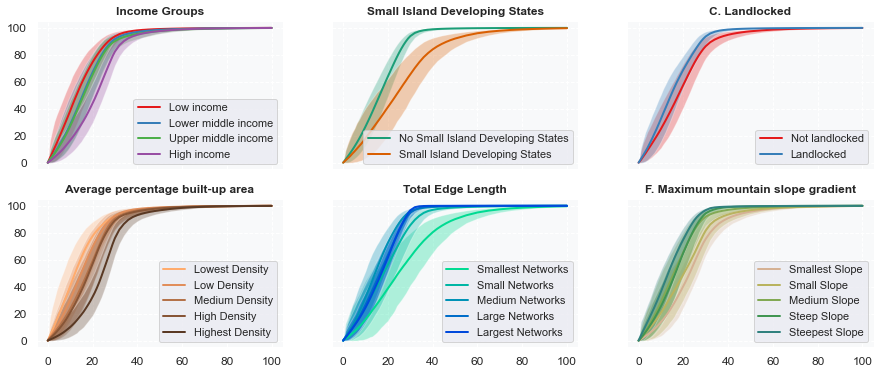

In [40]:
fig,axs = plt.subplots(2,3,figsize=(15,6),sharex=True,sharey=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('Income Groups',fontweight='bold')
          
    elif iter_ == 1: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Small Island Developing States',fontweight='bold')

    elif iter_ == 2: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
    
    
    elif iter_ == 3: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Average percentage built-up area',fontweight='bold')
            
    elif iter_ == 4: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Total Edge Length',fontweight='bold')
            
    elif iter_ == 5: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
    
    ax.tick_params(axis='both', which='major', labelsize=12)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)
    
plt.savefig('../figures/Random_attack_grouped_isolated.pdf',dpi=500,facecolor='white', bbox_inches='tight')


In [41]:
random_mean_isolated.groupby('IncomeLevel').mean().T[:101].iloc[20]

IncomeLevel
High income            44.367733
Low income             74.480345
Lower middle income    68.282200
Upper middle income    66.148333
Name: 20, dtype: float64

In [42]:
random_max_isolated.groupby('IncomeLevel').mean().T[:101].mean(axis=1).iloc[30]

94.74830996168582

In [43]:
random_min_isolated.groupby('IncomeLevel').mean().T[:101].mean(axis=1).iloc[44]

94.81407254150703

In [44]:
random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[0]][20]-random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[1]][20]

22.748555145826344

In [45]:
random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[0]][20]-random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[3]][20]

30.50213587236233

In [46]:
random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101]['Largest'][20]-random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101]['Smallest'][20]

34.60250174216028

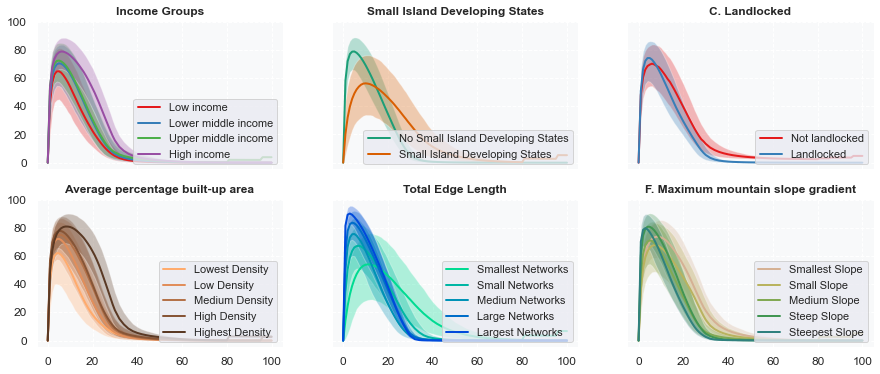

In [47]:
fig,axs = plt.subplots(2,3,figsize=(15,6),sharex=True,sharey=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('Income Groups',fontweight='bold')
          
    elif iter_ == 1: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Small Island Developing States',fontweight='bold')

    elif iter_ == 2: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_delayed.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_delayed.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_delayed.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
    
    
    elif iter_ == 3: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Average percentage built-up area',fontweight='bold')
            
    elif iter_ == 4: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Total Edge Length',fontweight='bold')
            
    elif iter_ == 5: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_delayed.loc[random_mean_delayed.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
    
    ax.tick_params(axis='both', which='major', labelsize=12)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)
    
plt.savefig('../figures/Random_attack_grouped_delayed.pdf',dpi=500,facecolor='white', bbox_inches='tight')


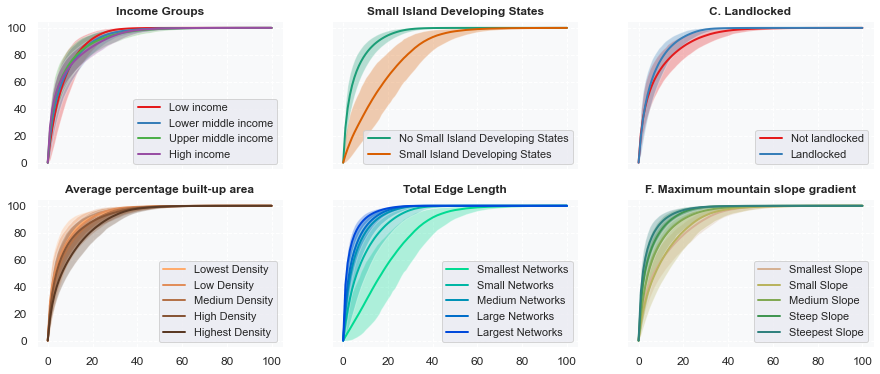

In [48]:
fig,axs = plt.subplots(2,3,figsize=(15,6),sharex=True,sharey=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('Income Groups',fontweight='bold')
          
    elif iter_ == 1: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Small Island Developing States',fontweight='bold')

    elif iter_ == 2: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_sloss_e1.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_sloss_e1.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_sloss_e1.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
    
    
    elif iter_ == 3: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Average percentage built-up area',fontweight='bold')
            
    elif iter_ == 4: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Total Edge Length',fontweight='bold')
            
    elif iter_ == 5: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_sloss_e1.loc[random_mean_sloss_e1.Total_Edge_Length > 1e5].groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
    
    ax.tick_params(axis='both', which='major', labelsize=12)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)
    
plt.savefig('../figures/Random_attack_grouped_sloss_e1.pdf',dpi=500,facecolor='white', bbox_inches='tight')


No handles with labels found to put in legend.


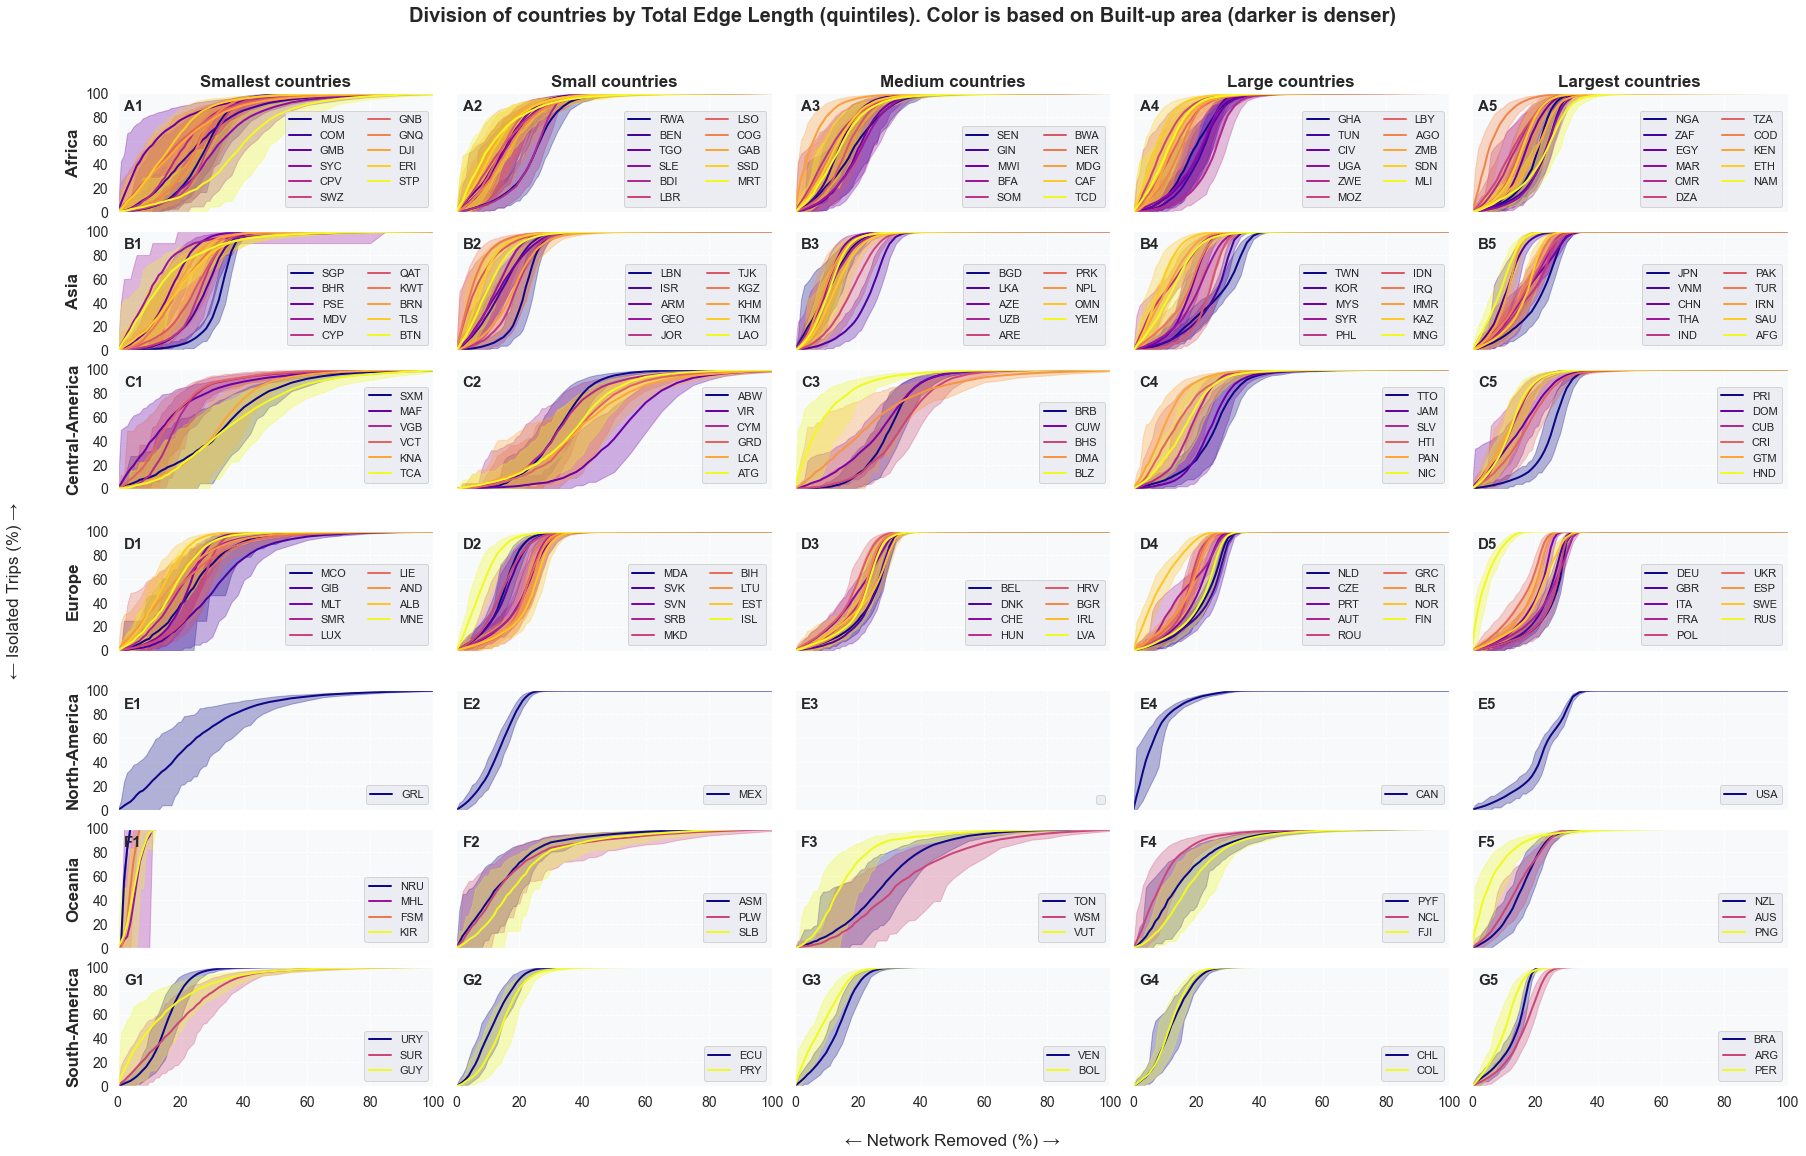

In [49]:
fig,axs = plt.subplots(7,5,figsize=(25,15),sharex=True,sharey=True,constrained_layout=True)
epochs = list(range(101))

iter_= 0

for cont_mean,cont_min,cont_max in zip(random_mean_isolated.groupby(['Continent']),
                                        random_min_isolated.groupby(['Continent']),random_max_isolated.groupby(['Continent'])):
    dfmean = cont_mean[1]
    dfmin = cont_min[1]
    dfmax = cont_max[1]
    
    column_to_jenk = 'Total_Edge_Length'
    jenks = dfmean[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dfmean['{}_binned'.format(column_to_jenk)] = pd.cut(dfmean[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmin['{}_binned'.format(column_to_jenk)] = pd.cut(dfmin[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmax['{}_binned'.format(column_to_jenk)] = pd.cut(dfmax[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])   
    
    axs[iter_,0].set_ylabel(cont_mean[0],fontsize=17,fontweight='bold')
    axs[iter_,0].set_yticks(np.arange(0,101,20))
    
    for iter2_,group in enumerate(dfmean.groupby(['{}_binned'.format(column_to_jenk)])):
        grouped = group[1].T[:101]  
        
        meanst = dfmean.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        min_plot = dfmin.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        max_plot = dfmax.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)

        cmap = cm.get_cmap('plasma', len(meanst.columns)) 

        for x in range(len(meanst.columns)):
            axs[iter_,iter2_].plot(epochs, meanst.iloc[:,x],label=meanst.columns[x],color=cmap(x), linewidth=2)
            axs[iter_,iter2_].fill_between(epochs, min_plot.iloc[:,x], max_plot.iloc[:,x],color=cmap(x) ,alpha=0.3, linewidth=1)

        if (len(min_plot.columns) > 7):
            axs[iter_,iter2_].legend(ncol=2,loc=4,prop={'size': 11})
        else:
            axs[iter_,iter2_].legend(loc=4,prop={'size': 11})

        axs[0,iter2_].set_title("{} countries".format(group[0]),fontsize=17,fontweight='bold')
            
        axs[iter_,iter2_].tick_params(axis='both', which='major', labelsize=14)   
        axs[iter_,iter2_].grid(True, linestyle='--')    
        axs[iter_,iter2_].set_facecolor('#f8f9fa')
        axs[iter_,iter2_].set_ylim(0,100) 
        axs[iter_,iter2_].set_xlim(0,100)        
        axs[iter_,iter2_].text(2,85,"{}{}".format(letters[iter_],iter2_+1),fontsize=15,fontweight='bold')
        #axs[iter_,iter2_].set_title("{}'s {}-sized countries.".format(cont_mean[0],group[0]),fontsize=14)
    iter_ += 1                                   
        
axs[6,2].text(50,-50,'\u2190 Network Removed (%) \u2192',ha='center',fontsize=17)
axs[3,0].text(-35,50,'\u2190 Isolated Trips (%) \u2192',va='center',fontsize=17,rotation=90)

#axs[0,3].text(-0.5,-0.3,'\u2190 Isolated Trips (%) \u2192',transform=axs[0,3].transAxes,ha='center',fontsize=15)
#axs[6,3].text(-0.5,0.1,'\u2190 Network removed (%) \u2192',transform=axs[6,3].transAxes,ha='center',rotation=90,fontsize=15) 

plt.suptitle('Division of countries by Total Edge Length (quintiles). Color is based on Built-up area (darker is denser)',fontsize=20,y=1.06,fontweight='bold')

plt.savefig('../figures/AreaSizeDivision_bycontinent.png',dpi=500,facecolor='white', bbox_inches='tight')

No handles with labels found to put in legend.


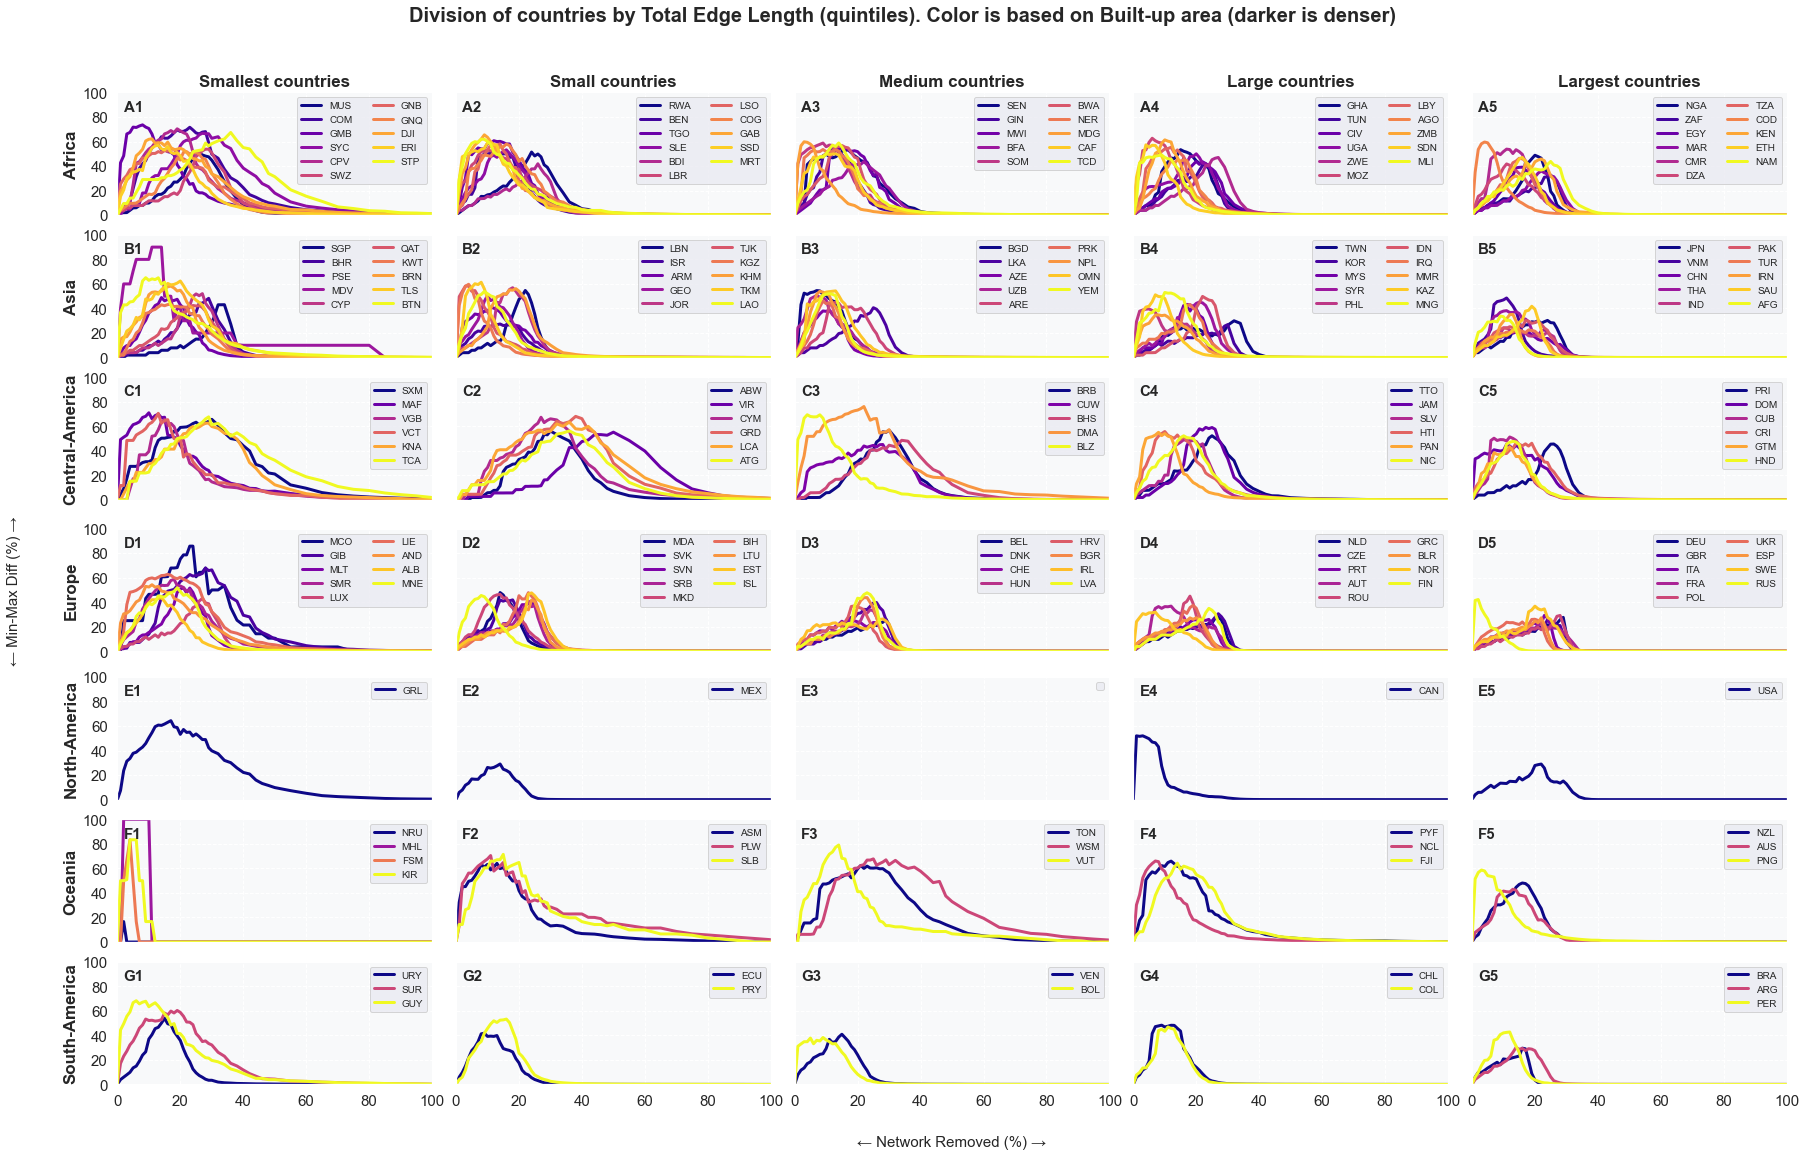

In [50]:
fig,axs = plt.subplots(7,5,figsize=(25,15),sharex=True,sharey=True,constrained_layout=True)
epochs = list(range(101))

iter_= 0
for cont_mean,cont_min,cont_max in zip(random_mean_isolated.groupby(['Continent']),
                                        random_min_isolated.groupby(['Continent']),random_max_isolated.groupby(['Continent'])):
    dfmean = cont_mean[1]
    dfmin = cont_min[1]
    dfmax = cont_max[1]
    
    column_to_jenk = 'Total_Edge_Length'
    jenks = dfmean[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dfmean['{}_binned'.format(column_to_jenk)] = pd.cut(dfmean[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmin['{}_binned'.format(column_to_jenk)] = pd.cut(dfmin[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmax['{}_binned'.format(column_to_jenk)] = pd.cut(dfmax[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])   
    
    axs[iter_,0].set_ylabel(cont_mean[0],fontsize=17,fontweight='bold')
    axs[iter_,0].set_yticks(np.arange(0,101,20))
    
    for iter2_,group in enumerate(dfmean.groupby(['{}_binned'.format(column_to_jenk)])):
        grouped = group[1].T[:101]  
        
        meanst = dfmean.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        min_plot = dfmin.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        max_plot = dfmax.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)

        diff = max_plot-min_plot
        cmap = cm.get_cmap('plasma', len(meanst.columns)) 

        #['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']#cm.get_cmap('plasma', len(meanst.columns)) 

        for x in range(len(meanst.columns)):
            axs[iter_,iter2_].plot(epochs,diff.iloc[:,x],label=diff.columns[x],color=cmap(x), linewidth=3)
            #axs[iter_,iter2_].fill_between(epochs, min_plot.iloc[:,x], max_plot.iloc[:,x],color=cmap(x) ,alpha=0.3, linewidth=1)

        if (len(min_plot.columns) > 7):
            axs[iter_,iter2_].legend(ncol=2,loc=1,prop={'size': 10})
        else:
            axs[iter_,iter2_].legend(loc=1,prop={'size': 10})

        axs[0,iter2_].set_title("{} countries".format(group[0]),fontsize=17,fontweight='bold')
            
        axs[iter_,iter2_].tick_params(axis='both', which='major', labelsize=15)   
        axs[iter_,iter2_].grid(True, linestyle='--')           
        axs[iter_,iter2_].set_facecolor('#f8f9fa')
        axs[iter_,iter2_].set_ylim(0,100) 
        axs[iter_,iter2_].set_xlim(0,100)        
        axs[iter_,iter2_].text(2,85,"{}{}".format(letters[iter_],iter2_+1),fontsize=15,fontweight='bold')
                #axs[iter_,iter2_].set_title("{}'s {}-sized countries.".format(cont_mean[0],group[0]),fontsize=14)
    iter_ += 1                                   

axs[6,2].text(50,-50,'\u2190 Network Removed (%) \u2192',ha='center',fontsize=15)
axs[3,0].text(-35,50,'\u2190 Min-Max Diff (%) \u2192',va='center',fontsize=15,rotation=90)
    
#axs[0,3].text(-0.5,-0.3,'\u2190 Isolated Trips (%) \u2192',transform=axs[0,3].transAxes,ha='center',fontsize=15)
#axs[6,3].text(-0.5,0.1,'\u2190 Network removed (%) \u2192',transform=axs[6,3].transAxes,ha='center',rotation=90,fontsize=15) 

plt.suptitle('Division of countries by Total Edge Length (quintiles). Color is based on Built-up area (darker is denser)',fontsize=20,y=1.06,fontweight='bold')

plt.savefig('../figures/AreaSizeDivision_bycontinent_minmaxdiff.png',dpi=500,facecolor='white', bbox_inches='tight')


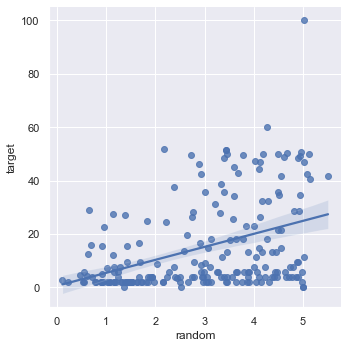

In [51]:
tar_vs_random = pd.DataFrame([target_results.max_pct_trips_isolated,random_mean_isolated.mean_gradient_isolated_0_20]).T.dropna()
tar_vs_random.columns = ['target','random']
sns.lmplot(x='random',y='target',data=tar_vs_random,fit_reg=True) 

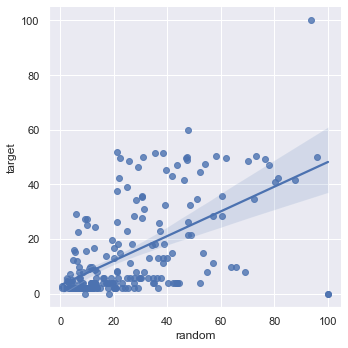

In [52]:
tar_vs_random = pd.DataFrame([target_results.max_pct_trips_isolated,random_mean_isolated[10]]).T.dropna()
tar_vs_random.columns = ['target','random']
sns.lmplot(x='random',y='target',data=tar_vs_random,fit_reg=True) 

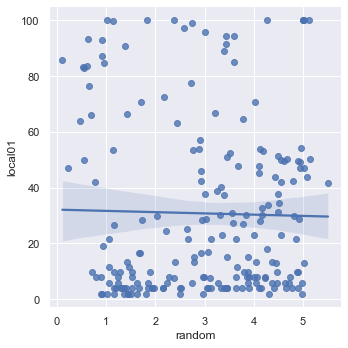

In [53]:
loc_vs_random = pd.DataFrame([local_results_01.max_pct_trips_isolated_01,random_mean_isolated.mean_gradient_isolated_0_20]).T.dropna()
loc_vs_random.columns = ['local01','random']
sns.lmplot(x='random',y='local01',data=loc_vs_random,fit_reg=True) 

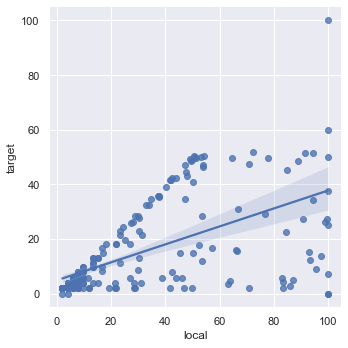

In [54]:
loc_vs_tar = pd.DataFrame([local_results_01.max_pct_trips_isolated_01,target_results.max_pct_trips_isolated]).T.dropna()
loc_vs_tar.columns = ['local','target']
sns.lmplot(x='local',y='target',data=loc_vs_tar,fit_reg=True) 

In [55]:
gadm36_to_plot = gadm36.merge(target_results,
             left_on='GID_0',right_index=True)

<AxesSubplot:>

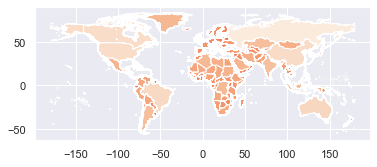

In [56]:
gadm36_to_plot.plot('logAREA')

In [57]:
## collect all

df_results = pd.concat([local_results_05.max_pct_trips_isolated_05,local_results_05.pct_grids_cause_isolation_05,
                        local_results_05.max_pct_trips_delayed_05,local_results_05.pct_grids_cause_delay_05,
                        local_results_01.max_pct_trips_isolated_01,local_results_01.pct_grids_cause_isolation_01,
                        local_results_01.max_pct_trips_delayed_01,local_results_01.pct_grids_cause_delay_01,
                        local_results_005.max_pct_trips_isolated_005,local_results_005.pct_grids_cause_isolation_005,
                        local_results_005.max_pct_trips_delayed_005,local_results_005.pct_grids_cause_delay_005,
                        target_results.max_pct_trips_isolated,target_results.pct_edges_cause_isolation,
                        target_results.max_pct_trips_delayed,target_results.pct_edges_cause_delay,
                        random_mean_isolated.mean_gradient_isolated_0_20,random_mean_isolated.mean_gradient_delayed_0_20
          ],axis=1)

In [58]:
df_results['loc05'] = ((df_results.max_pct_trips_isolated_05/df_results.max_pct_trips_isolated_05.max())+
                        (df_results.pct_grids_cause_isolation_05/df_results.pct_grids_cause_isolation_05.max()) +
                           (df_results.max_pct_trips_delayed_05/df_results.max_pct_trips_delayed_05.max())+
                            (df_results.pct_grids_cause_delay_05/df_results.pct_grids_cause_delay_05.max()))/4

df_results['loc01'] = ((df_results.max_pct_trips_isolated_01/df_results.max_pct_trips_isolated_01.max())+
                        (df_results.pct_grids_cause_isolation_01/df_results.pct_grids_cause_isolation_01.max()) +
                           (df_results.max_pct_trips_delayed_01/df_results.max_pct_trips_delayed_01.max())+
                            (df_results.pct_grids_cause_delay_01/df_results.pct_grids_cause_delay_01.max()))/4

df_results['loc005'] = ((df_results.max_pct_trips_isolated_005/df_results.max_pct_trips_isolated_005.max())+
                        (df_results.pct_grids_cause_isolation_005/df_results.pct_grids_cause_isolation_005.max()) +
                           (df_results.max_pct_trips_delayed_005/df_results.max_pct_trips_delayed_005.max())+
                            (df_results.pct_grids_cause_delay_005/df_results.pct_grids_cause_delay_005.max()))/4

df_results['target'] = ((df_results.max_pct_trips_isolated/df_results.max_pct_trips_isolated.max())+
                        (df_results.pct_edges_cause_isolation/df_results.pct_edges_cause_isolation.max()) +
                           (df_results.max_pct_trips_delayed/df_results.max_pct_trips_delayed.max())+
                            (df_results.pct_edges_cause_delay/df_results.pct_edges_cause_delay.max()))/4

df_results['random'] = (df_results.mean_gradient_isolated_0_20/df_results.mean_gradient_isolated_0_20.max()+
                        df_results.mean_gradient_delayed_0_20/df_results.mean_gradient_delayed_0_20.max())/2

df_results['avg_index'] =  (df_results.loc05+df_results.loc01+df_results.loc005+df_results.target+df_results.random)/5
df_results['ranked'] = df_results.avg_index.rank()

In [59]:
gadm36_to_plot = gadm36.merge(df_results,
             left_on='GID_0',right_index=True)

In [60]:
ranking = gadm36_to_plot[['NAME_0','loc05','loc01','loc005','target','random','avg_index','ranked']]

In [61]:
ranking.to_csv('../results/ranked_all.csv')